In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from beakerx import *

from pycta.portfolio import Portfolio
from pycta.analysis import Analysis

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load prices
prices = pd.read_csv("data/p_ob.csv", index_col=0, parse_dates=True).ffill().truncate(before="1970-01-01")

We use the system:
$$\mathrm{CashPosition}=\frac{f(\mathrm{Price})}{\mathrm{Volatility(Returns)}}$$

This is very problematic:
* Prices may live on very different scales, hence trying to find a more universal function $f$ is almost impossible. The sign-function was a good choice as the results don't depend on the scale of the argument.
* Price may come with all sorts of spikes/outliers/problems.

We need a simple price filter process
* We compute volatility-adjusted returns, filter them and compute prices from those returns. 
* Don't call it Winsorizing in Switzerland. We apply Huber functions. 


In [3]:
def filter(price, volatility=32,clip=4.2, min_periods=300):    
    r = np.log(price).diff()
    vola = r.ewm(com=volatility, min_periods=min_periods).std()
    price_adj = (r/vola).clip(-clip, clip).cumsum()
    return price_adj

### Oscillators
* All prices are now following a standard arithmetic Brownian motion with std $1$.
* What we want is the difference of two moving means (exponentially weighted) to have a constant std regardless of the two lengths.
* An oscillator is the **scaled difference of two moving averages**.


In [4]:
import numpy as np
def osc(prices, fast=32, slow=96, scaling=True):
    diff = prices.ewm(com=fast-1).mean() - prices.ewm(com=slow-1).mean()
    if scaling:
        s = diff.std()
    else:
        s = 1

    return diff/s

In [5]:
from numpy.random import randn
import pandas as pd
price = pd.Series(data=randn(100000)).cumsum()

o = osc(price, 40, 200, scaling=True)
print("The std for the oscillator (Should be close to 1.0):")
print(np.std(o))

The std for the oscillator (Should be close to 1.0):
0.9999949999874997


In [6]:
#from pycta.signal import osc

# take two moving averages and apply tanh
def f(price, slow=96, fast=32, clip=3):
    # construct a fake-price, those fake-prices have homescedastic returns
    price_adj = filter(price, volatility=slow, clip=clip)
    # compute mu
    mu = np.tanh(osc(price_adj, fast=fast, slow=slow))
    return mu/price.pct_change().ewm(com=slow, min_periods=300).std()

In [7]:
portfolio = Portfolio(prices=prices, position=prices.apply(f))

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
a = Analysis(portfolio.nav())
a.performance

Performance number
Annua Return                        13.23
Annua Volatility                    16.03
Annua Sharpe Ratio (r_f = 0)         0.83
Max Drawdown                        43.44
Return                          43,995.05
Kurtosis                             9.07
dtype: object

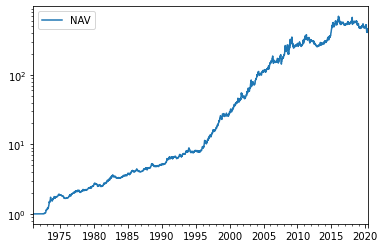

In [9]:
a.nav.plot(logy=True)
plt.show()

In [ ]:
a.monthlytable

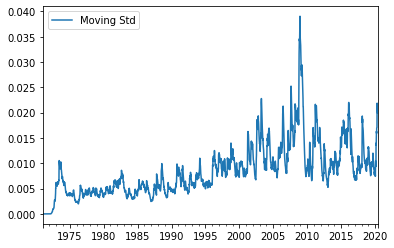

In [10]:
a.std.plot(kind="line")
plt.show()

This system is still **univariate** and lacks **integrated risk management**:

$$\mathrm{CashPosition}=\frac{f(\mathrm{Filter}(\mathrm{Price}))}{\mathrm{Volatility(Returns)}}=\frac{\mu}{\mathrm{Volatility}}$$

Some hedge funds stop here. All energy goes into constructing $\mu$.

* Suitable as it is possible to add/remove additional systems on the fly.
* A typical CTA would run with a set of $5$ or $6$ functions $f$ acting on approx. $100$ assets. 
* Organisation by asset group.
* Scaled signals make it easy to apply functions such as $\tanh$ or combine various signals in a regression problem.